In [5]:
pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Active Learning**

In [6]:
import pandas as pd
df = pd.read_csv(r"Corona_NLP.csv")
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [7]:
df = df.apply(lambda x: pd.factorize(x)[0])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,0,0,0,0,0,0
1,1,1,1,0,1,1
2,2,2,-1,0,2,2
3,3,3,2,0,3,3
4,4,4,3,1,4,4
...,...,...,...,...,...,...
3793,3793,3793,1714,14,3793,1
3794,3794,3794,1715,14,3794,3
3795,3795,3795,1716,14,3795,4
3796,3796,3796,-1,14,3796,0


In [8]:
df = df.drop('UserName', axis=1)
df

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,0,0,0,0,0
1,1,1,0,1,1
2,2,-1,0,2,2
3,3,2,0,3,3
4,4,3,1,4,4
...,...,...,...,...,...
3793,3793,1714,14,3793,1
3794,3794,1715,14,3794,3
3795,3795,1716,14,3795,4
3796,3796,-1,14,3796,0


In [9]:
df = df.drop('ScreenName', axis=1)
df

,Location,TweetAt,OriginalTweet,Sentiment
0,0,0,0,0
1,1,0,1,1
2,-1,0,2,2
3,2,0,3,3
4,3,1,4,4
...,...,...,...,...
3793,1714,14,3793,1
3794,1715,14,3794,3
3795,1716,14,3795,4
3796,-1,14,3796,0


In [10]:
X_raw= df.values[:, :]
y_raw= df.values[:, 0]

In [11]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [12]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

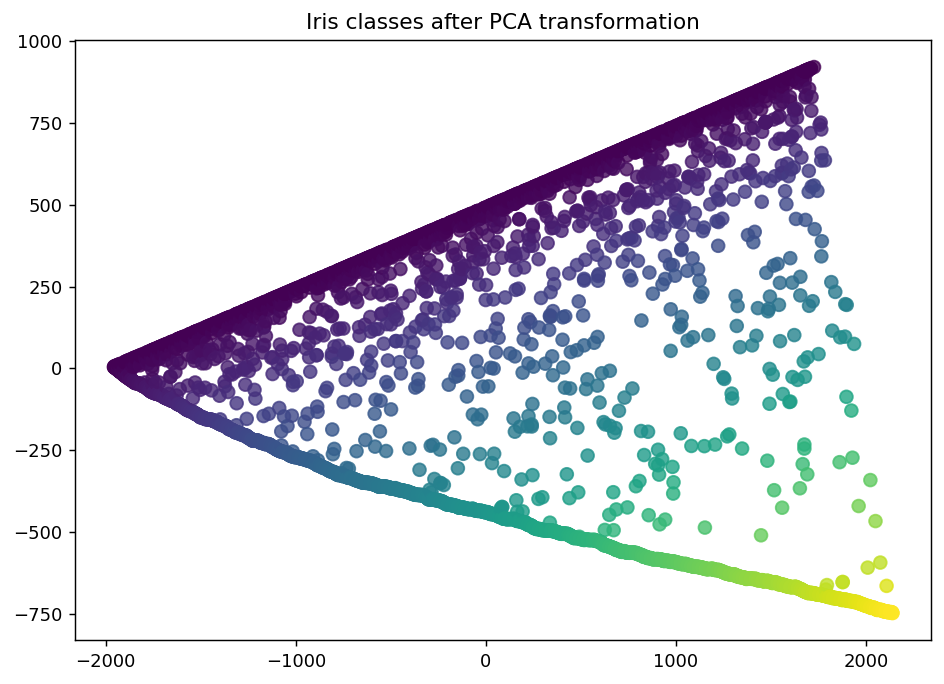

In [13]:
from matplotlib import colors
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10,)
plt.title('Iris classes after PCA transformation')
plt.show()

In [14]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [16]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([10, 10, 10, ..., 10, 10, 10])

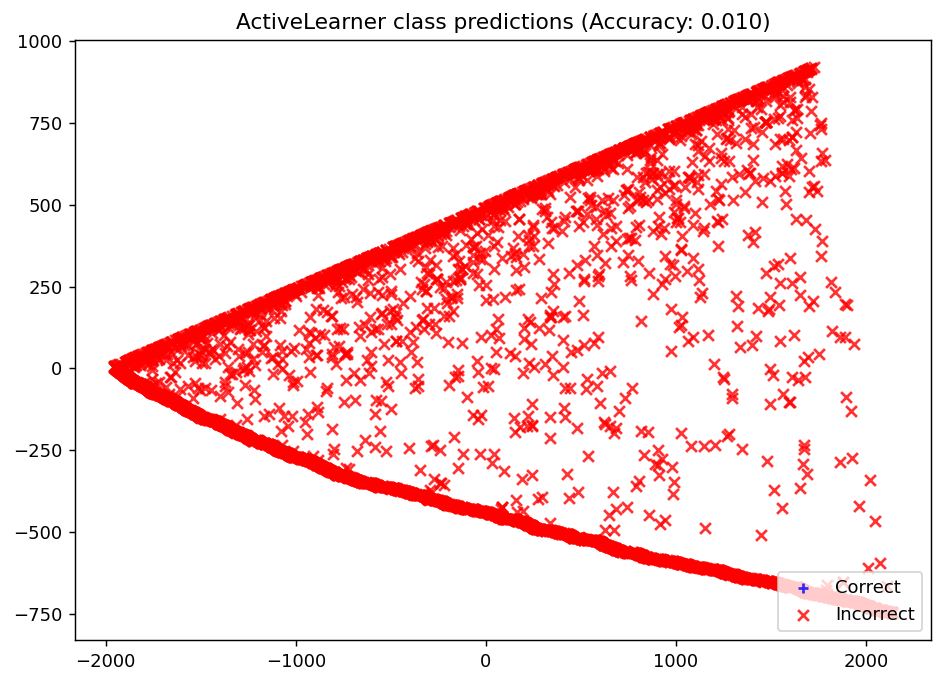

In [17]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='red', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [18]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.0076
Accuracy after query 2: 0.0074
Accuracy after query 3: 0.1319
Accuracy after query 4: 0.1108
Accuracy after query 5: 0.1103
Accuracy after query 6: 0.0076
Accuracy after query 7: 0.1319
Accuracy after query 8: 0.1111
Accuracy after query 9: 0.1103
Accuracy after query 10: 0.0074
Accuracy after query 11: 0.0082
Accuracy after query 12: 0.0068
Accuracy after query 13: 0.1316
Accuracy after query 14: 0.1114
Accuracy after query 15: 0.1114
Accuracy after query 16: 0.0132
Accuracy after query 17: 0.0092
Accuracy after query 18: 0.1322
Accuracy after query 19: 0.1124
Accuracy after query 20: 0.1119
Accuracy after query 21: 0.0142
Accuracy after query 22: 0.0111
Accuracy after query 23: 0.0118
Accuracy after query 24: 0.0095
Accuracy after query 25: 0.0095
Accuracy after query 26: 0.0129
Accuracy after query 27: 0.0095
Accuracy after query 28: 0.0095
Accuracy after query 29: 0.0195
Accuracy after query 30: 0.0097


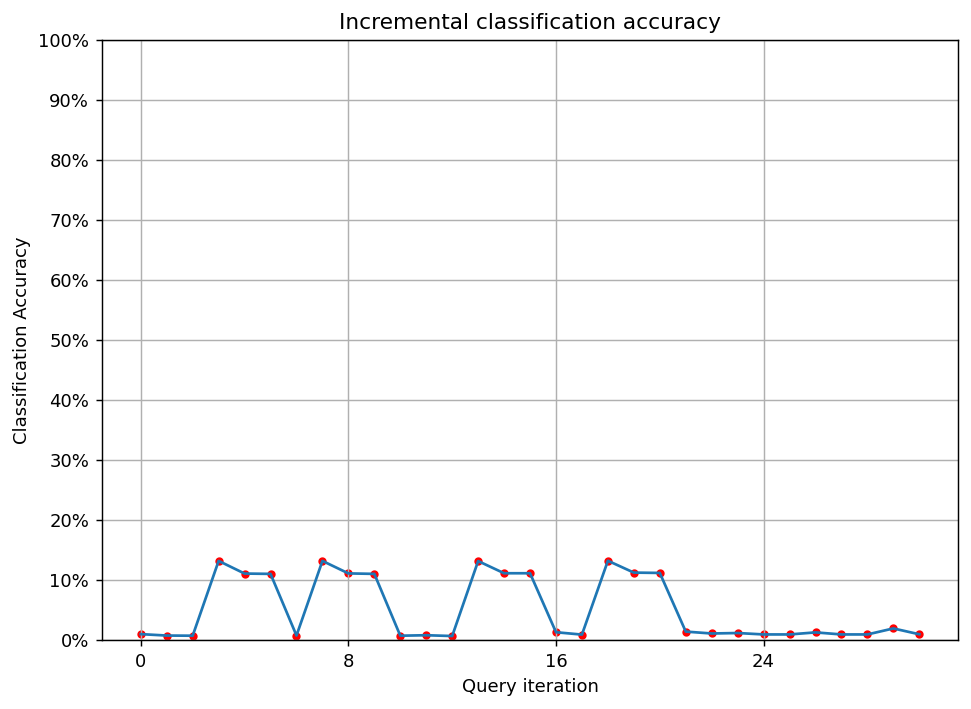

In [19]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13, c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

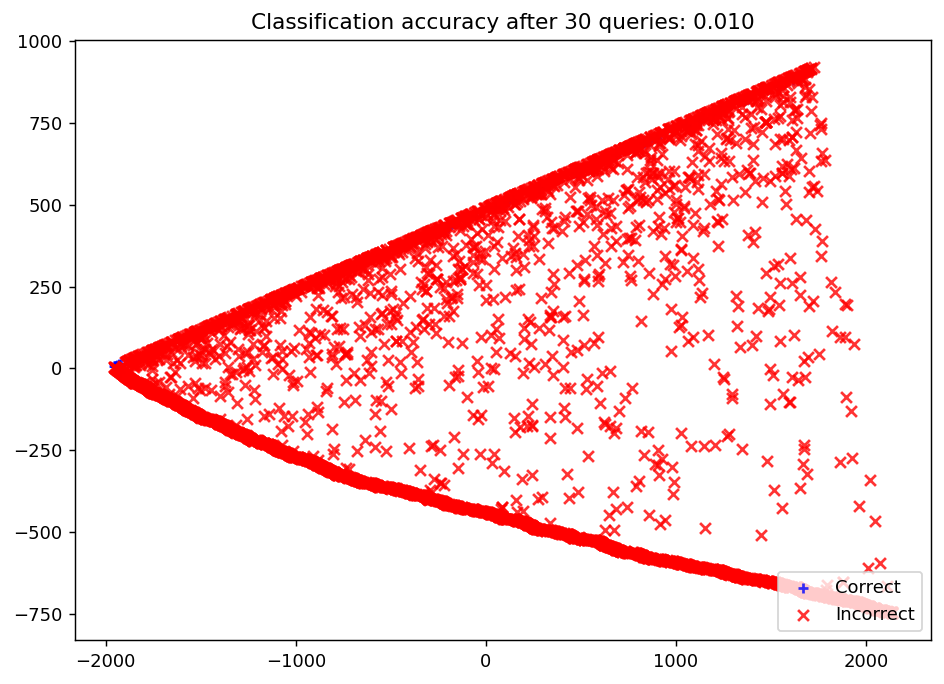

In [20]:
  # Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Margin**

In [21]:
from sklearn.tree import DecisionTreeClassifier
from modAL.uncertainty import margin_sampling

In [22]:
X_raw3= df.values[:, 1:23]
y_raw3= df.values[:, 0]

In [23]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw3)

In [24]:
# Isolate our examples for our labeled dataset.
n_labeled_examples3 = X_raw3.shape[0]
training_indices3 = np.random.randint(low=0, high=n_labeled_examples3, size=5)

X_train3 = X_raw3[training_indices3]
y_train3 = y_raw3[training_indices3]

# Isolate the non-training examples we'll be querying.
X_pool3 = np.delete(X_raw3, training_indices3, axis=0)
y_pool3 = np.delete(y_raw3, training_indices3, axis=0)

In [25]:
learner = ActiveLearner(
    estimator = DecisionTreeClassifier(criterion="entropy", max_depth = 7,min_samples_split=5),
    query_strategy=margin_sampling,
    X_training=X_train3, y_training=y_train3
)

In [26]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

predictions


array([-1, -1, -1, ..., 10, 10, 10])

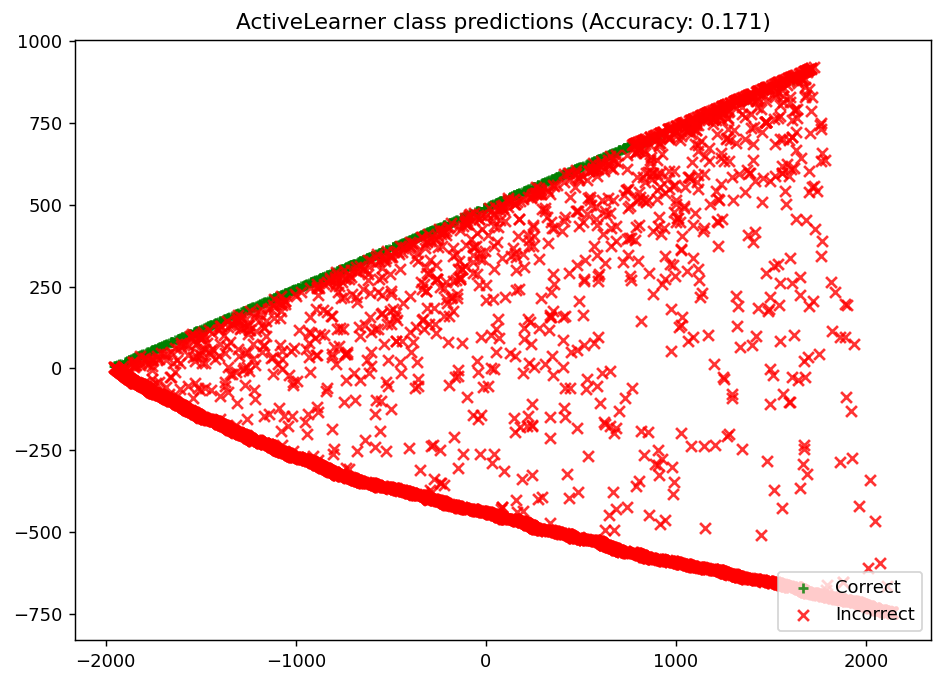

In [27]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw3, y_raw3)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [28]:
N_QUERIES = 50
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool3)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool3[query_index].reshape(1, -1), y_pool3[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool3, y_pool3 = np.delete(X_pool3, query_index, axis=0), np.delete(y_pool3, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw3, y_raw3)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.1706
Accuracy after query 2: 0.1706
Accuracy after query 3: 0.0785
Accuracy after query 4: 0.0742
Accuracy after query 5: 0.0985
Accuracy after query 6: 0.0732
Accuracy after query 7: 0.0745
Accuracy after query 8: 0.0740
Accuracy after query 9: 0.0429
Accuracy after query 10: 0.0458
Accuracy after query 11: 0.0432
Accuracy after query 12: 0.0463
Accuracy after query 13: 0.0450
Accuracy after query 14: 0.0748
Accuracy after query 15: 0.0735
Accuracy after query 16: 0.0719
Accuracy after query 17: 0.0653
Accuracy after query 18: 0.0624
Accuracy after query 19: 0.0613
Accuracy after query 20: 0.0629
Accuracy after query 21: 0.0987
Accuracy after query 22: 0.0613
Accuracy after query 23: 0.0613
Accuracy after query 24: 0.0732
Accuracy after query 25: 0.0753
Accuracy after query 26: 0.0724
Accuracy after query 27: 0.0621
Accuracy after query 28: 0.0682
Accuracy after query 29: 0.0700
Accuracy after query 30: 0.0674
Accuracy after query 31: 0.0661
Accuracy after qu

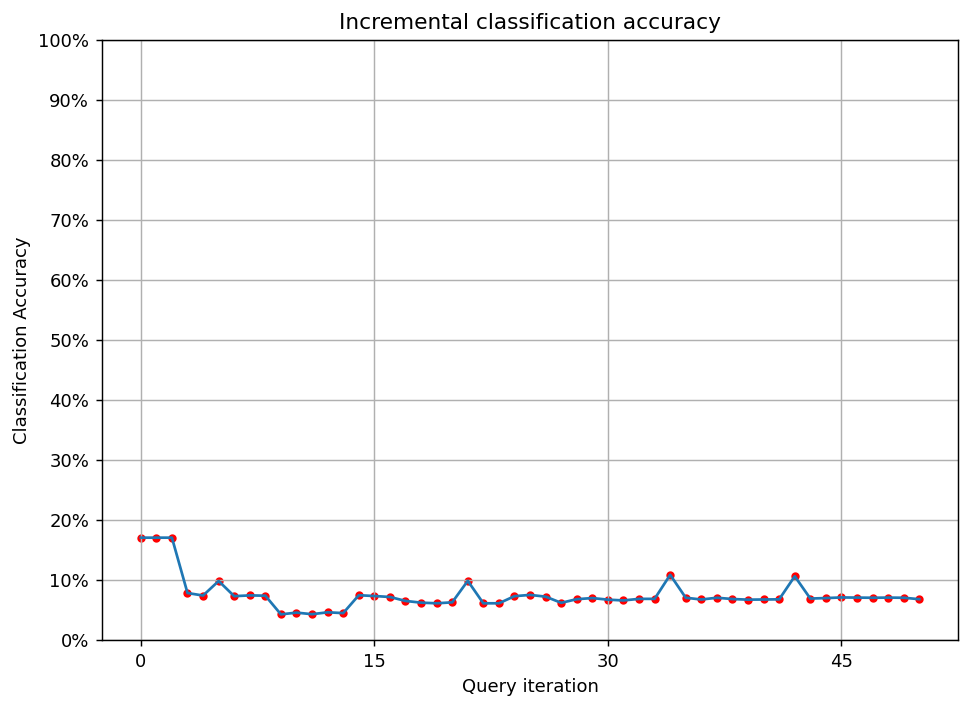

In [29]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13,c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

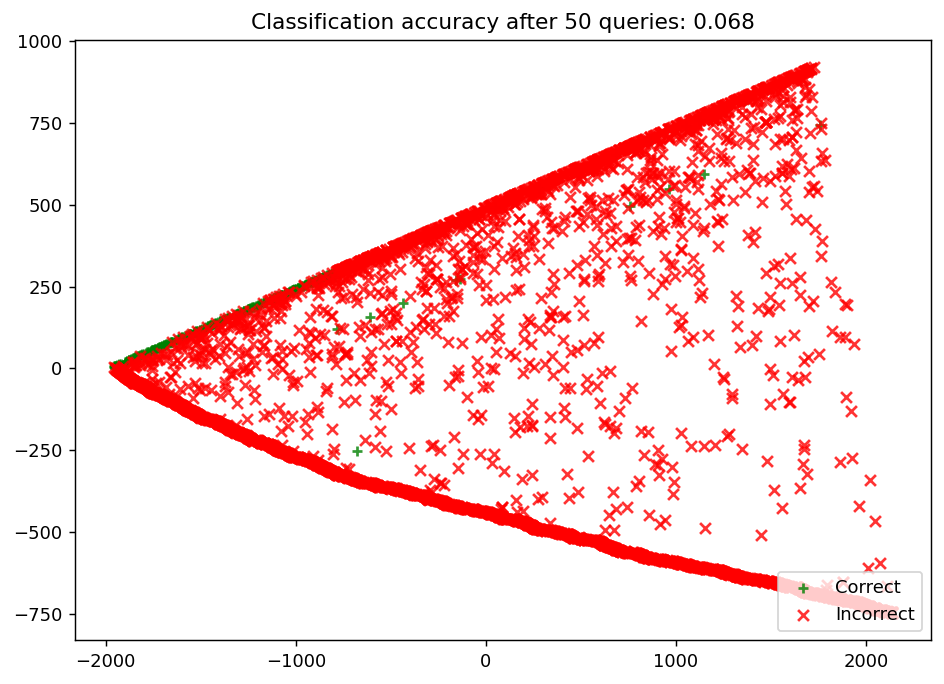

In [30]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Random sampling strategy**

In [31]:
X_raw1= df.values[:, 1:23]
y_raw1= df.values[:, 0]

In [32]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw1)

In [33]:
# Isolate our examples for our labeled dataset.
n_labeled_examples1 = X_raw1.shape[0]
training_indices1 = np.random.randint(low=0, high=n_labeled_examples1, size=3)

X_train1 = X_raw1[training_indices1]
y_train1 = y_raw1[training_indices1]

# Isolate the non-training examples we'll be querying.
X_pool1 = np.delete(X_raw1, training_indices1, axis=0)
y_pool1 = np.delete(y_raw1, training_indices1, axis=0)

In [34]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool1[query_idx]

learner = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors=3),
    query_strategy=random_sampling,
    X_training=X_train1, y_training=y_train1
)

In [35]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

predictions


array([10, 10, 10, ..., 10, 10, 10])

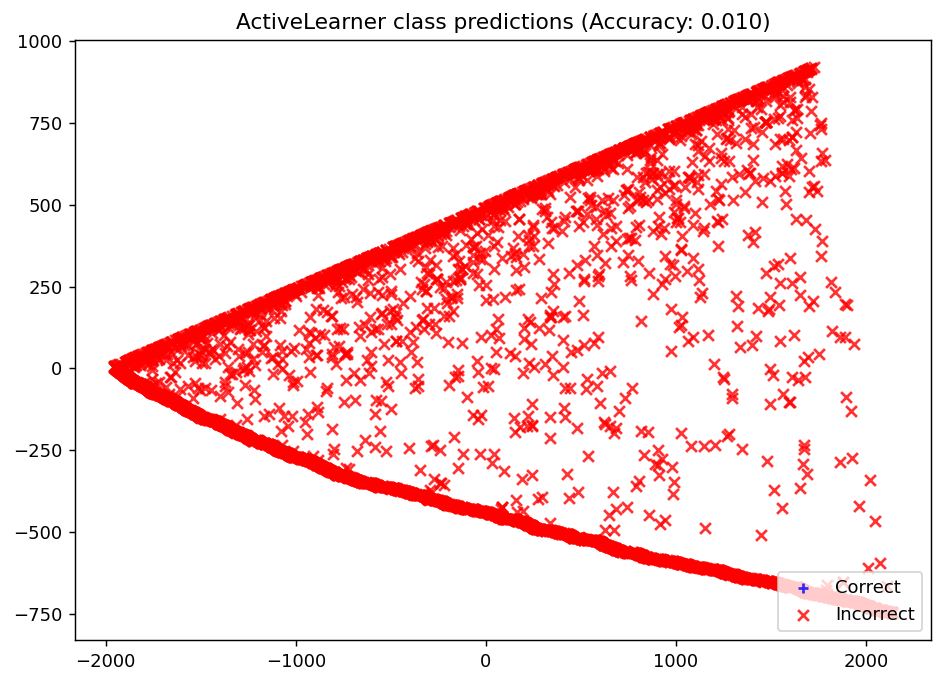

In [36]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw1, y_raw1)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [37]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool1)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool1[query_index].reshape(1, -1), y_pool1[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool1, y_pool1 = np.delete(X_pool1, query_index, axis=0), np.delete(y_pool1, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw1, y_raw1)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.0100
Accuracy after query 2: 0.1393
Accuracy after query 3: 0.1388
Accuracy after query 4: 0.1290
Accuracy after query 5: 0.1288
Accuracy after query 6: 0.1053
Accuracy after query 7: 0.0961
Accuracy after query 8: 0.0906
Accuracy after query 9: 0.0906
Accuracy after query 10: 0.0903
Accuracy after query 11: 0.0903
Accuracy after query 12: 0.1369
Accuracy after query 13: 0.1295
Accuracy after query 14: 0.1295
Accuracy after query 15: 0.1003
Accuracy after query 16: 0.1003
Accuracy after query 17: 0.0998
Accuracy after query 18: 0.0937
Accuracy after query 19: 0.0958
Accuracy after query 20: 0.0956
Accuracy after query 21: 0.0877
Accuracy after query 22: 0.0814
Accuracy after query 23: 0.0972
Accuracy after query 24: 0.0903
Accuracy after query 25: 0.0919
Accuracy after query 26: 0.0874
Accuracy after query 27: 0.0866
Accuracy after query 28: 0.0969
Accuracy after query 29: 0.0898
Accuracy after query 30: 0.0898


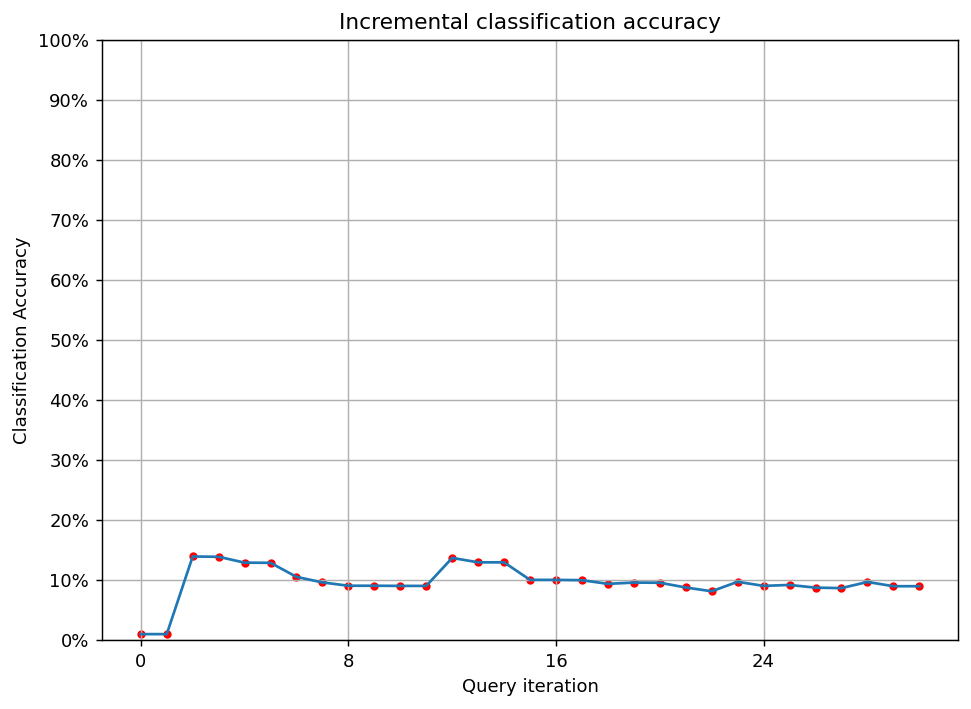

In [38]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13, c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

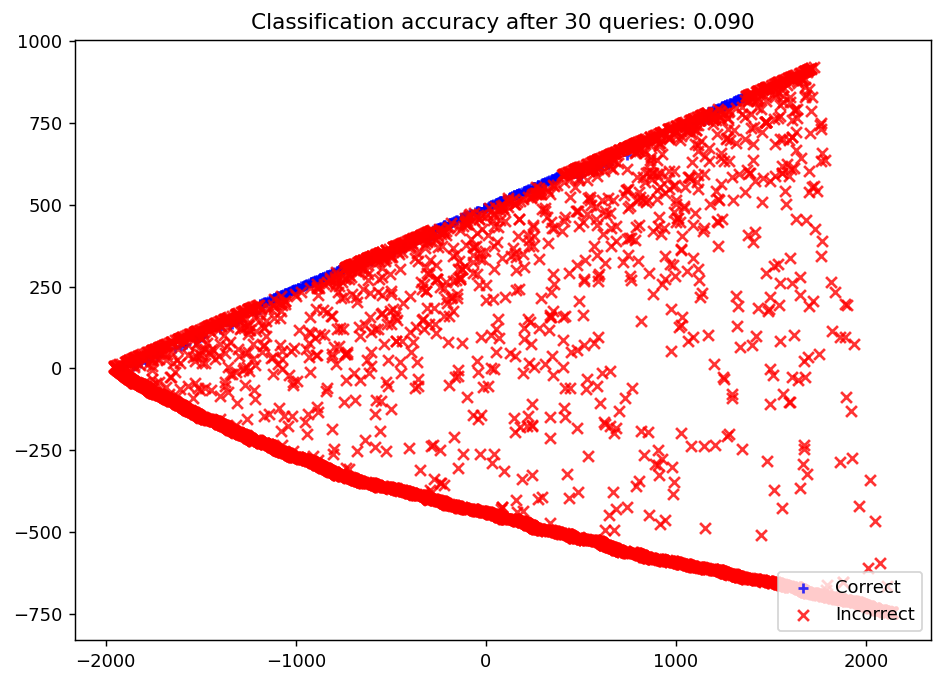

In [39]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Entropy sampling strategy**


In [40]:
from modAL.uncertainty import entropy_sampling

In [41]:
X_raw1= df.values[:, 1:23]
y_raw1= df.values[:, 0]

In [42]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw1)

In [43]:
# Isolate our examples for our labeled dataset.
n_labeled_examples2 = X_raw1.shape[0]
training_indices2 = np.random.randint(low=0, high=n_labeled_examples2, size=3)

X_train2 = X_raw1[training_indices2]
y_train2 = y_raw1[training_indices2]

# Isolate the non-training examples we'll be querying.
X_pool2 = np.delete(X_raw1, training_indices2, axis=0)
y_pool2 = np.delete(y_raw1, training_indices2, axis=0)

In [44]:
learner = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors=3),
    query_strategy=entropy_sampling,
    X_training=X_train2, y_training=y_train2
)

In [45]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

predictions


array([10, 10, 10, ..., 10, 10, 10])

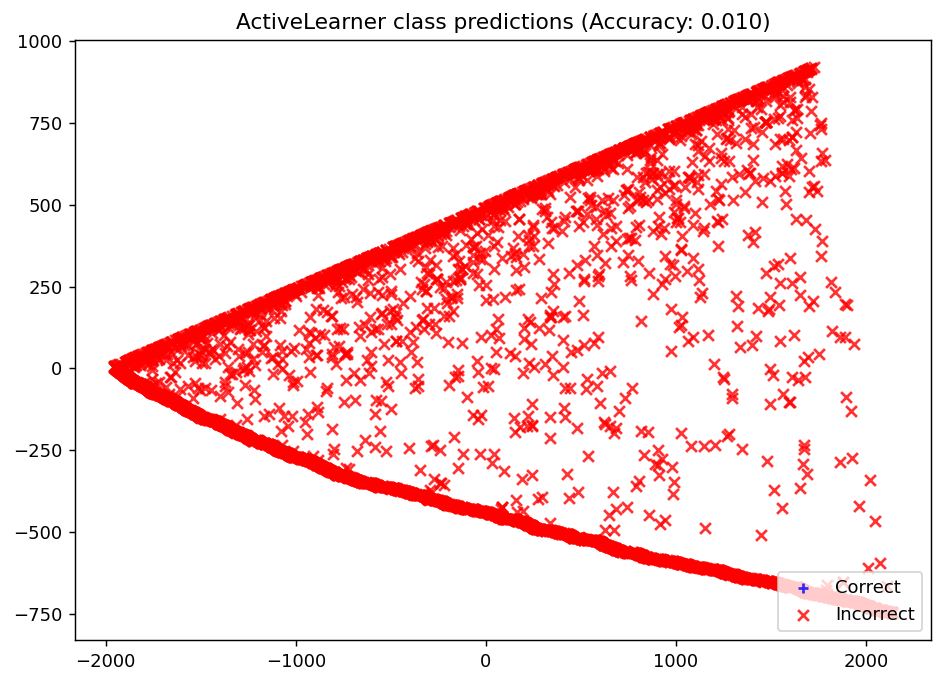

In [46]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw1, y_raw1)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [47]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool2)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool2[query_index].reshape(1, -1), y_pool2[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool2, y_pool2 = np.delete(X_pool2, query_index, axis=0), np.delete(y_pool2, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw1, y_raw1)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.0079
Accuracy after query 2: 0.0079
Accuracy after query 3: 0.1153
Accuracy after query 4: 0.1116
Accuracy after query 5: 0.1111
Accuracy after query 6: 0.0076
Accuracy after query 7: 0.1153
Accuracy after query 8: 0.1116
Accuracy after query 9: 0.1153
Accuracy after query 10: 0.1116
Accuracy after query 11: 0.1111
Accuracy after query 12: 0.0524
Accuracy after query 13: 0.0606
Accuracy after query 14: 0.1219
Accuracy after query 15: 0.1230
Accuracy after query 16: 0.1380
Accuracy after query 17: 0.1377
Accuracy after query 18: 0.1377
Accuracy after query 19: 0.1295
Accuracy after query 20: 0.1324
Accuracy after query 21: 0.1301
Accuracy after query 22: 0.1301
Accuracy after query 23: 0.1256
Accuracy after query 24: 0.1256
Accuracy after query 25: 0.1256
Accuracy after query 26: 0.1256
Accuracy after query 27: 0.1256
Accuracy after query 28: 0.1256
Accuracy after query 29: 0.1256
Accuracy after query 30: 0.1245


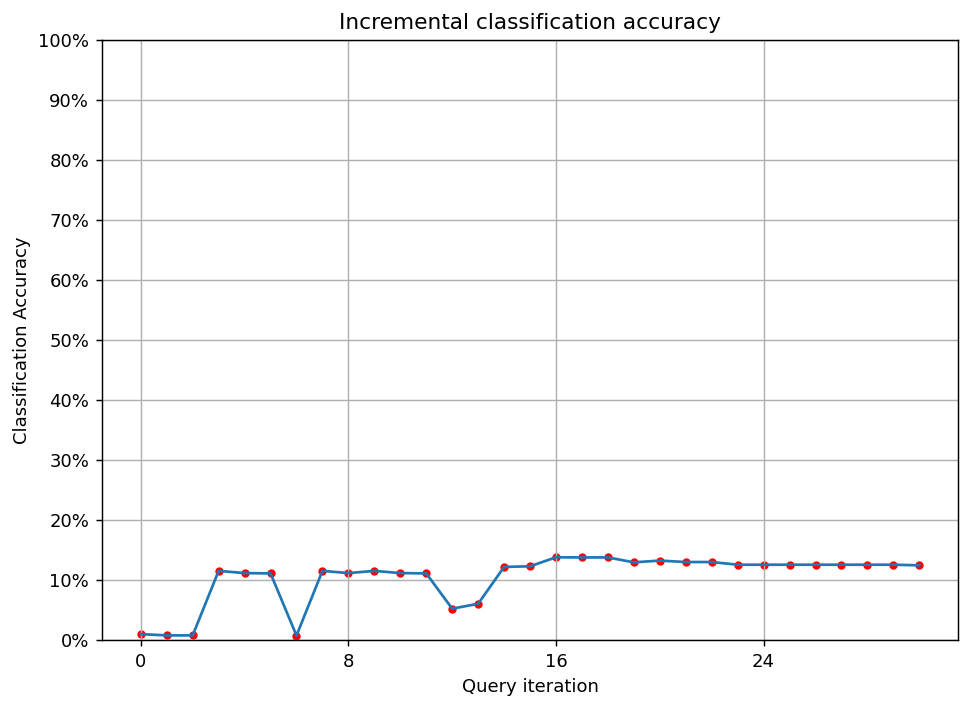

In [48]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13,c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

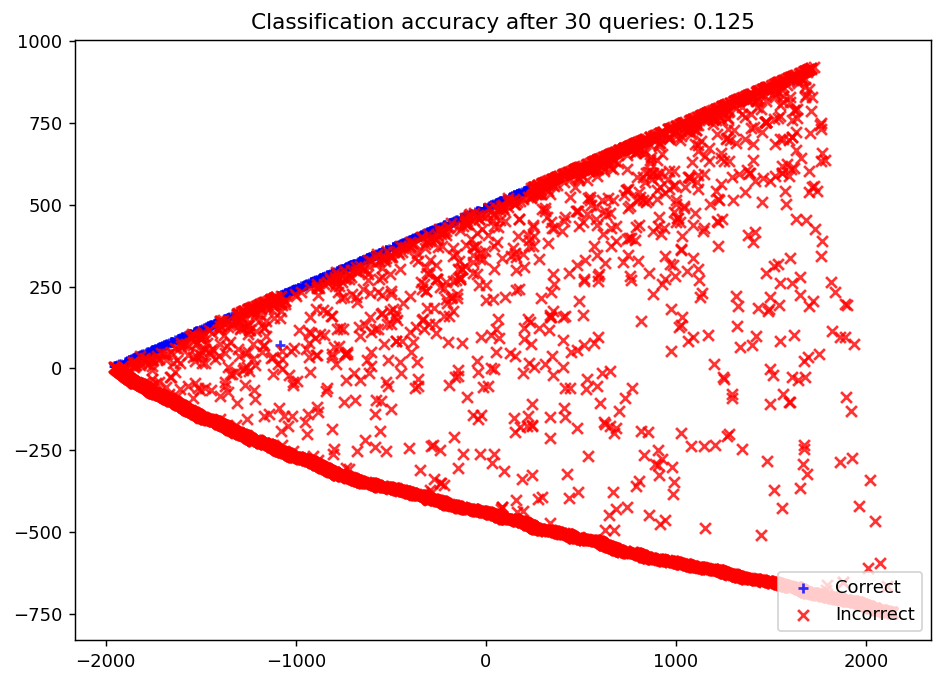

In [49]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Uncertainity sampling**

In [50]:
# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [51]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions


array([10, 10, 10, ..., 10, 10, 10])

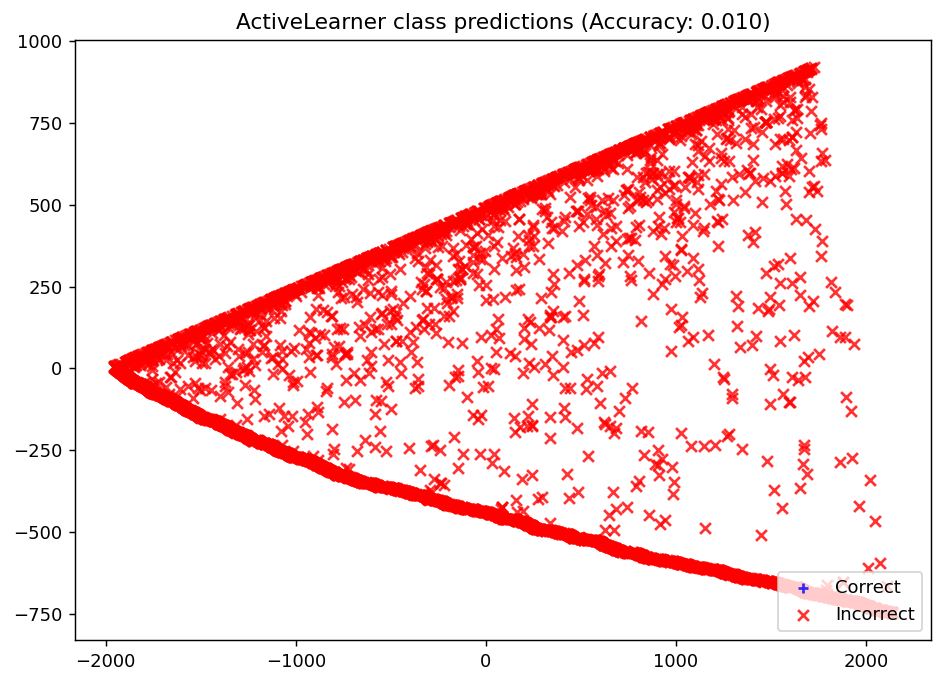

In [52]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [53]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.1319
Accuracy after query 2: 0.1327
Accuracy after query 3: 0.1124
Accuracy after query 4: 0.1122
Accuracy after query 5: 0.0669
Accuracy after query 6: 0.0561
Accuracy after query 7: 0.0371
Accuracy after query 8: 0.0369
Accuracy after query 9: 0.0229
Accuracy after query 10: 0.0229
Accuracy after query 11: 0.0150
Accuracy after query 12: 0.0150
Accuracy after query 13: 0.0116
Accuracy after query 14: 0.0116
Accuracy after query 15: 0.0108
Accuracy after query 16: 0.0105
Accuracy after query 17: 0.0105
Accuracy after query 18: 0.0108
Accuracy after query 19: 0.0132
Accuracy after query 20: 0.0132
Accuracy after query 21: 0.0132
Accuracy after query 22: 0.0132
Accuracy after query 23: 0.0132
Accuracy after query 24: 0.0132
Accuracy after query 25: 0.0132
Accuracy after query 26: 0.0132
Accuracy after query 27: 0.0134
Accuracy after query 28: 0.0134
Accuracy after query 29: 0.0129
Accuracy after query 30: 0.0134


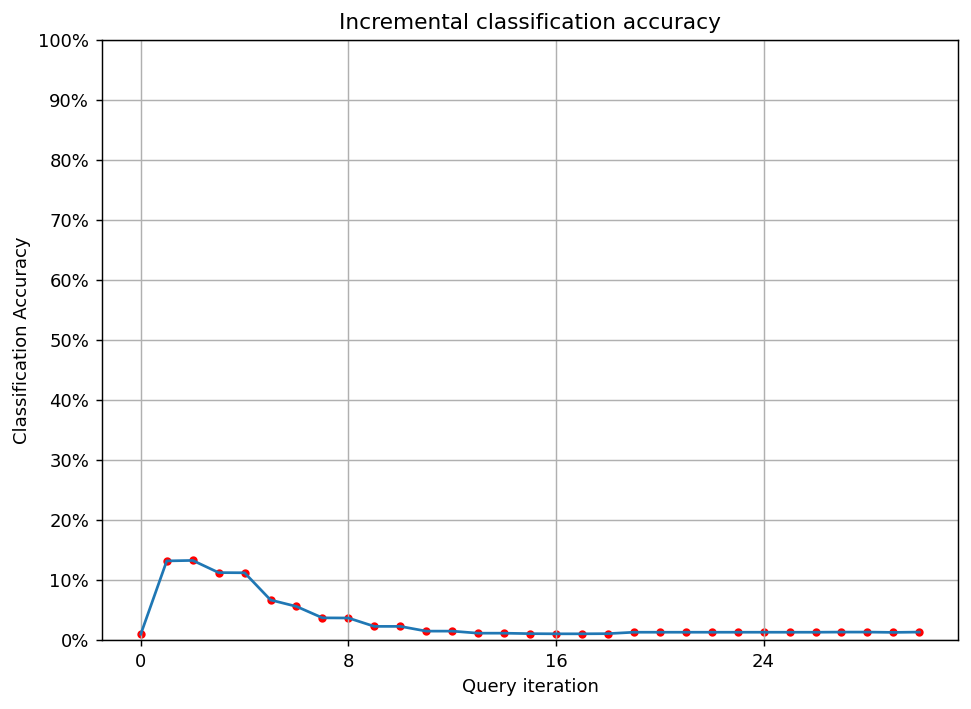

In [54]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13,c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

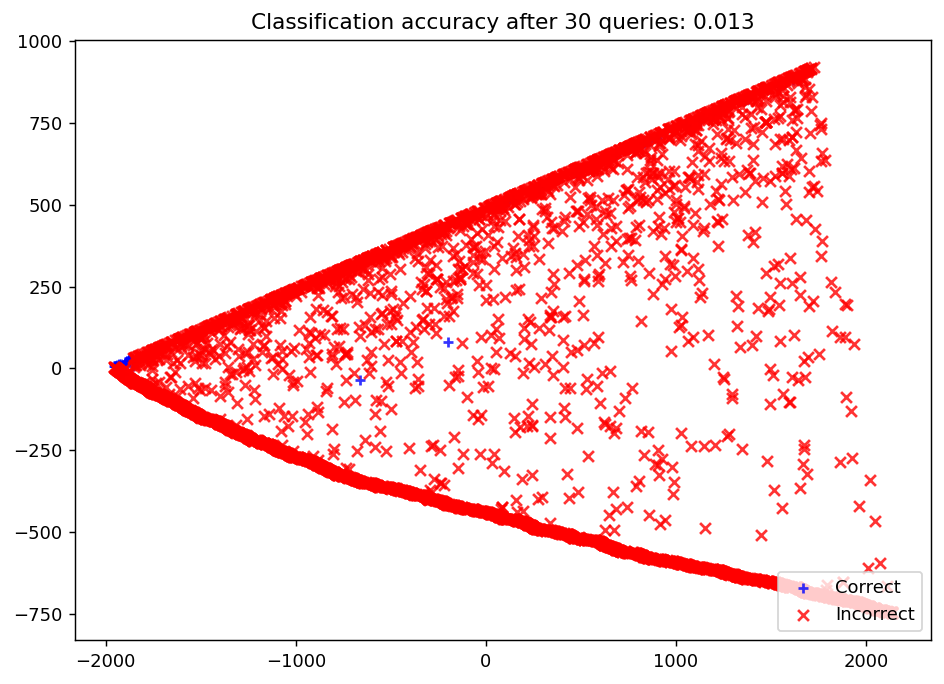

In [55]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()